# Imports

In [110]:

import csv
from datetime import datetime
import os

import matplotlib.pyplot as plt
import mlflow
import mlflow.tensorflow
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import minmax_scale
from source.custom_layer import NBeatsBlock
from source.utils import *
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (
    Dense,
    Dropout,
    Lambda,
    Conv1D,
    Input,
    LSTM,
    subtract,
    add
    )
from tensorflow.keras.utils import plot_model

# Get Data

In [112]:

X_train, X_test, y_train, y_test = load_data(save_dir='../data/features')

In [113]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2229,), (558,), (2229,), (558,))

In [3]:
bitcoin_prices, timesteps, prices = load_btc_data()

# MLflow set-up

In [4]:
mlflow.set_tracking_uri('../data/mlruns')

In [5]:
mlflow.set_experiment('BitPredict-experiments')

2023/10/29 13:25:37 INFO mlflow.tracking.fluent: Experiment with name 'BitPredict-experiments' does not exist. Creating a new experiment.


<Experiment: artifact_location='/home/pop/Documents/Projects/BitPredict/bitpredict_system/notebooks/../data/mlruns/450922989925476463', creation_time=1698596737038, experiment_id='450922989925476463', last_update_time=1698596737038, lifecycle_stage='active', name='BitPredict-experiments', tags={}>

# Modelling Experiments

## Horizon and window

- **horizon** = Number of timesteps to predict into future.
- **window** = Number of timesteps from past used to predict horizon.

| Model Number | Model Type | Horizon size | Window size | Extra data |
|---|---|---|---|---|
| 0 | Naïve model (baseline) | NA | NA | NA |
| 1 | Dense model | 1 | 7 | NA |
| 2 | Same as 1 | 1 | 30 | NA |
| 3 | Same as 1 | 7 | 30 | NA |
| 4 | Conv1D | 1 | 7 | NA |
| 5 | LSTM | 1 | 7 | NA |
| 6 | Same as 1 (but with multivariate data) | 1 | 7 | Block reward size |
| 7 | N-BEATS Algorithm | 1 | 7 | NA |
| 8 | Ensemble (multiple models optimized on different loss functions) | 1 | 7 | NA |
| 9 | Future prediction model (model to predict future values) | 1 | 7 | NA |
| 10 | Same as 1 (but with turkey data introduced) | 1 | 7 | NA |


# Model 0: Naive forecast (baseline)

In [6]:
# Create a naive forecast
naive_forecast = y_test[:-1]
naive_forecast[:10], naive_forecast[-10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

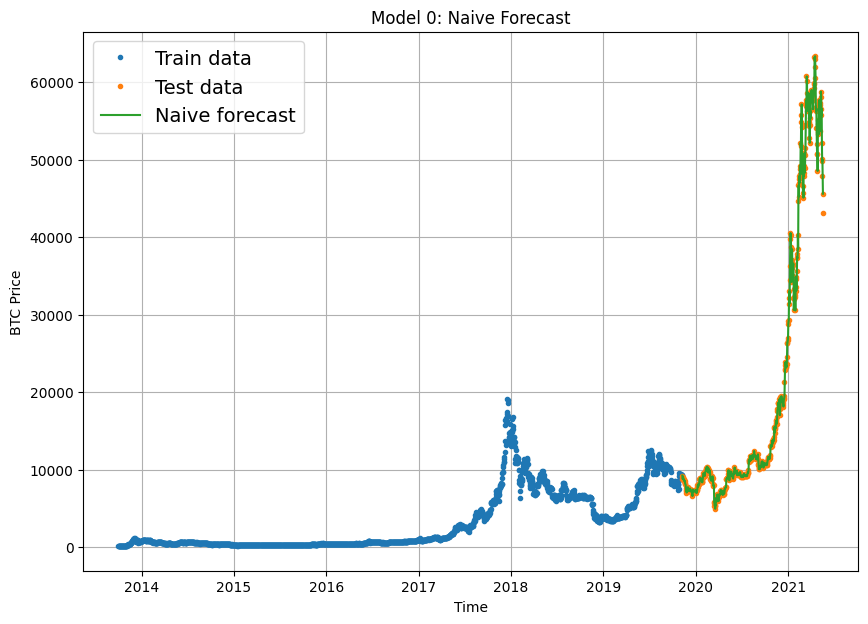

In [117]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
plt.title('Model 0: Naive Forecast')
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", label="Naive forecast");

Let's zoom in to take a better look. We can do so by creating an offset value and passing it to the `start` parameter of our `plot_time_series()` function.

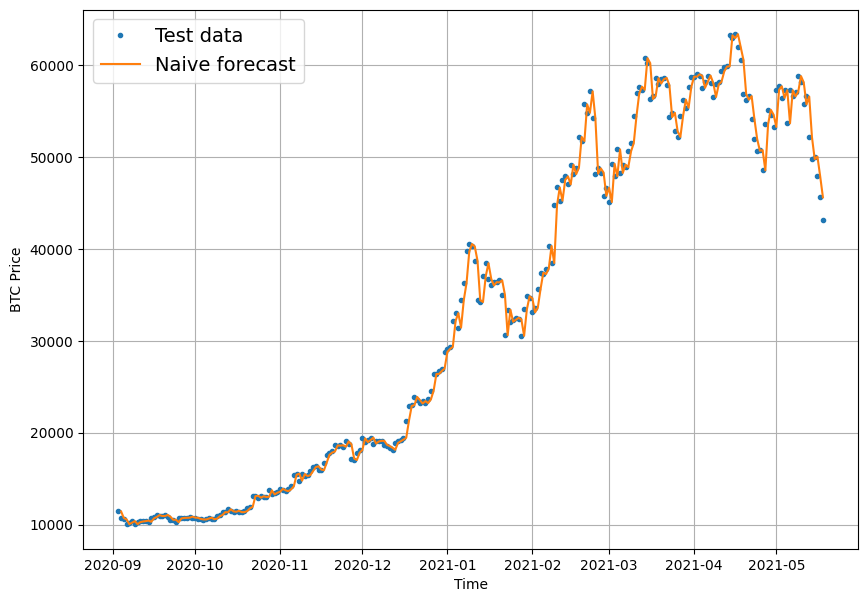

In [8]:
plt.figure(figsize=(10, 7))
offset = 300 # offset the values by 300 timesteps 
plot_time_series(timesteps=X_test, values=y_test, start=offset, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", start=offset, label="Naive forecast");

# Evaluating a time series model

📖 Resource: We're going to be using several metrics to evaluate our different model's time series forecast accuracy. Many of them are sourced and explained mathematically and conceptually in `Forecasting: Principles and Practice chapter 5.8`.

| Metric | Details | Code |
|---|---|---|
| MAE (mean absolute error) | the MAE will lead to forecasts of the median | `tf.keras.metrics.mean_absolute_error()` |
| RMSE (root mean square error) | Forecasts which minimise the RMSE lead to forecasts of the mean. | `tf.sqrt(tf.keras.metrics.mean_squared_error())` |
| MAPE (mean absolute percentage error) | Most commonly used percentage error. May explode (not work) if `y=0` | `tf.keras.metrics.mean_absolute_percentage_error()` |
| SMAPE (symmetric mean absolute percentage error) | Recommended not to be used by `Forecasting: Principles and Practice`, though it is used in forecasting competitions, | Custom implementation |
| MASE (mean absolute scaled error). | MASE equals one for the naive forecast (or very close to one). A forecast which performs better than the naïve should get <1 MASE. | See sktime's `mase_loss()` |


In [9]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.99957}

Taking a look at the naïve forecast's MAE, it seems on average each forecast is ~$567 different than the actual Bitcoin price. How does this compare to the average price of Bitcoin in the test dataset?

# Windowed Dataset

For a univariate time series, windowing for one week (`window=7`) to predict the next single value (`horizon=1`) for the price of Bitcoin, it'd look like:

```
Window for one week with the target of predicting the next day (Bitcoin prices)

[123.654, 125.455, 108.584, 118.674, 121.338, 120.655, 121.795] -> [123.033]
[125.455, 108.584, 118.674, 121.338, 120.655, 121.795, 123.033] -> [124.049]
[108.584, 118.674, 121.338, 120.655, 121.795, 123.033, 124.049] -> [125.961]
```

In [10]:
# predict 1 step at a time
HORIZON = 1
# use a week worth of timesteps to predict the horizon
WINDOW_SIZE = 7

In [11]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8


## Creating windows for dataset

In [12]:
full_windows, full_labels = make_windows(
    prices,
    window_size=WINDOW_SIZE,
    horizon=HORIZON
)

In [13]:
len(full_windows), len(full_labels)

(2780, 2780)

In [14]:
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


🔑 **Note**: You can find a function which achieves similar results to the ones we implemented in the `utils` module `tf.keras.preprocessing.timeseries_dataset_from_array()`. Just like ours, it takes in an array and returns a windowed dataset. It has the benefit of returning data in the form of a `tf.data.Dataset` instance (we'll see how to do this with our own data later).

## Turning windows into training and test sets

We could've windowed our existing training and test splits, however, with the nature of windowing (windowing often requires an offset at some point in the data), it usually works better to window the data first, then split it into training and test sets

In [15]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)

In [16]:
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

# Model 1: Dense model (window = 7, horizon = 1)

In [17]:
tf.random.set_seed(42)

model_1 = tf.keras.Sequential(
    [
        Dense(128, activation='relu'),
        Dense(HORIZON, activation='linear')
    ],
    name='model_1_dense'
)

model_1.compile(
    loss = 'mae',
    optimizer=Adam(),
    metrics=['mae']
)

In [18]:
with mlflow.start_run():
    
    run_name = 'model_1_dense'
    mlflow.set_tag('mlflow.runName', run_name)
    mlflow.tensorflow.autolog()
    
    model_1.fit(
        x=train_windows,
        y=train_labels,
        epochs=100,
        batch_size=128,
        verbose=0,
        validation_data=(test_windows, test_labels),
        callbacks=[create_model_checkpoint(model_name=model_1.name)]
    )

2023/10/29 13:25:40 WARNING mlflow.tensorflow: Encountered unexpected error while inferring batch size from training dataset: 'Sequential' object has no attribute '_nested_inputs'
2023/10/29 13:25:40 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/pop/Documents/Projects/BitPredict/bitpredict_system/.venv/lib/python3.10/site-packages/mlflow/tensorflow/_autolog.py:48: UserWarning: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data."


INFO:tensorflow:Assets written to: ../data/model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_1_dense/assets
2023/10/29 13:25:58 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: tuple index out of range
2023/10/29 13:25:58 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /tmp/tmpcytvcs4m/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpcytvcs4m/model/data/model/assets
2023/10/29 13:26:02 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/pop/Documents/Projects/BitPredict/bitpredict_system/.venv/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."


## model 1 evaluation

In [19]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1024      
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1153 (4.50 KB)
Trainable params: 1153 (4.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 737.7830 - mae: 737.7830


[737.7830200195312, 737.7830200195312]

In [21]:
model_1 = tf.keras.models.load_model('../data/model_experiments/model_1_dense')
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 567.3574 - mae: 567.3574


[567.357421875, 567.357421875]

Due to the fluctuating performance of the model during training, loading back in the best performing model see's a sizeable improvement in MAE.

In [22]:
model_1_preds = make_preds(model_1, test_windows)

model_1_results = evaluate_preds(
    y_true=tf.squeeze(test_labels),
    y_pred=model_1_preds
)

model_1_results

 1/18 [>.............................] - ETA: 1s

18/18 [==============================] - 0s 1ms/step


{'mae': 567.35736,
 'mse': 1162003.5,
 'rmse': 1077.9626,
 'mape': 2.5506501,
 'mase': 0.99668974}

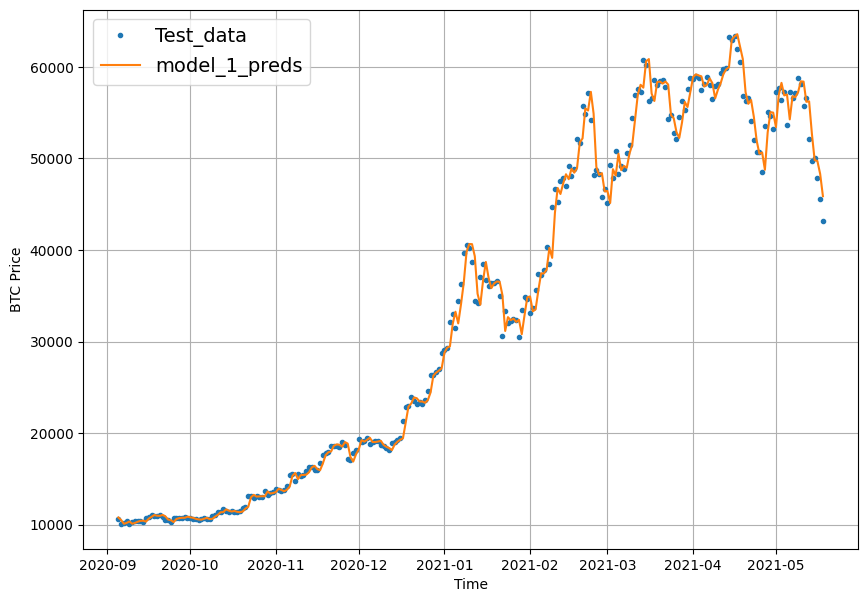

In [23]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(
    timesteps=X_test[-len(test_windows):],
    values=test_labels[:, 0],
    start=offset,
    label="Test_data")
plot_time_series(
    timesteps=X_test[-len(test_windows):],
    values=model_1_preds,
    start=offset,
    format="-",
    label="model_1_preds")
plt.savefig('../data/images/experiments/plot_model_1.png')
mlflow.log_artifact('../data/images/experiments/plot_model_1.png')
mlflow.end_run()

# Model 2: Dense (window = 30, horizon = 1)

In [24]:
HORIZON = 1 # predict one step at a time
WINDOW_SIZE = 30 # use 30 timesteps in the past

# Make windowed data with appropriate horizon and window sizes
full_windows, full_labels = make_windows(
    prices,
    window_size=WINDOW_SIZE,
    horizon=HORIZON)

# Make train and testing windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(
    windows=full_windows,
    labels=full_labels)

In [25]:
# Create model (same model as model 1 but data input will be different)
model_2 = tf.keras.Sequential([
  Dense(128, activation="relu"),
  Dense(HORIZON) # need to predict horizon number of steps into the future
], name="model_2_dense")

model_2.compile(loss="mae",
                optimizer=Adam())

In [26]:
with mlflow.start_run():
    
    run_name = 'model_2_dense'
    mlflow.set_tag('mlflow.runName', run_name)
    mlflow.tensorflow.autolog()
    
    model_2.fit(
        x=train_windows,
        y=train_labels,
        epochs=100,
        batch_size=128,
        verbose=0,
        validation_data=(test_windows, test_labels),
        callbacks=[create_model_checkpoint(model_name=model_2.name)]
    )

2023/10/29 13:26:04 WARNING mlflow.tensorflow: Encountered unexpected error while inferring batch size from training dataset: 'Sequential' object has no attribute '_nested_inputs'
2023/10/29 13:26:04 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/pop/Documents/Projects/BitPredict/bitpredict_system/.venv/lib/python3.10/site-packages/mlflow/tensorflow/_autolog.py:48: UserWarning: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data."


INFO:tensorflow:Assets written to: ../data/model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_2_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_2_dense/assets
2023/10/29 13:26:16 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: tuple index out of range
2023/10/29 13:26:16 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /tmp/tmp1c4npk4_/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmp1c4npk4_/model/data/model/assets


## model 2 evaluation

In [27]:
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 645.2073


645.2073364257812

In [28]:
# Load in best performing model
model_2 = tf.keras.models.load_model("../data/model_experiments/model_2_dense/")
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 617.7903


617.7903442382812

In [29]:
# Get forecast predictions
model_2_preds = make_preds(model_2,
                           input_data=test_windows)

18/18 [==============================] - 0s 1ms/step


In [30]:
# Evaluate results for model 2 predictions
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels), # remove 1 dimension of test labels
                                 y_pred=model_2_preds)
model_2_results

{'mae': 617.79034,
 'mse': 1324576.2,
 'rmse': 1150.9023,
 'mape': 2.8232074,
 'mase': 1.0799035}

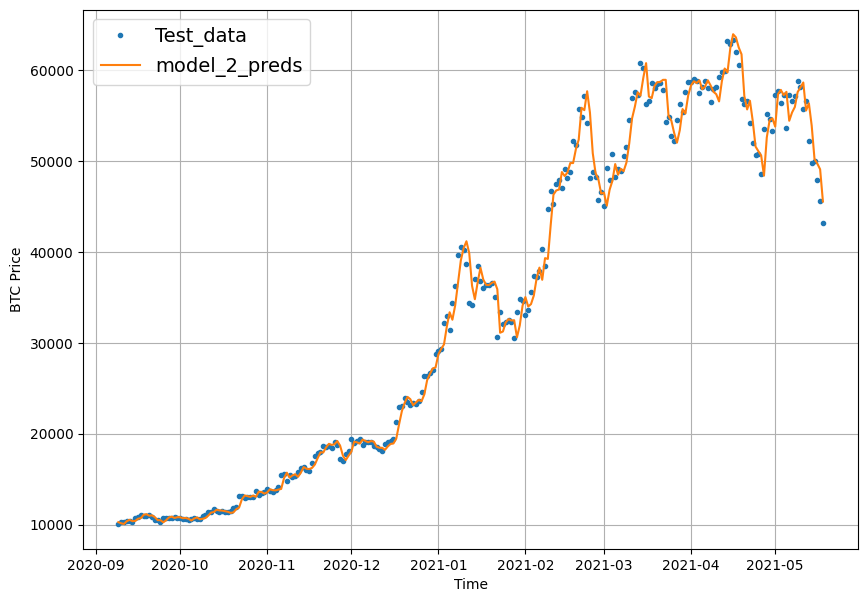

In [31]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(
    timesteps=X_test[-len(test_windows):],
    values=test_labels[:, 0],
    start=offset,
    label="Test_data")
plot_time_series(
    timesteps=X_test[-len(test_windows):],
    values=model_2_preds,
    start=offset,
    format="-",
    label="model_2_preds")
plt.savefig('../data/images/experiments/plot_model_2.png')
mlflow.log_artifact('../data/images/experiments/plot_model_2.png')
mlflow.end_run()

# Model 3: Dense (window = 30, horizon = 7)

In [32]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)

In [33]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(
    windows=full_windows,
    labels=full_labels,
    test_split=0.2)

In [34]:
# Create model (same model as model 1 but data input will be different)
model_3 = tf.keras.Sequential([
  Dense(128, activation="relu"),
  Dense(HORIZON) # need to predict horizon number of steps into the future
], name="model_3_dense")

model_3.compile(loss="mae",
                optimizer=Adam())

In [35]:
with mlflow.start_run():
    
    run_name = 'model_3_dense'
    mlflow.set_tag('mlflow.runName', run_name)
    mlflow.tensorflow.autolog()
    
    model_3.fit(
        x=train_windows,
        y=train_labels,
        epochs=100,
        batch_size=128,
        verbose=0,
        validation_data=(test_windows, test_labels),
        callbacks=[create_model_checkpoint(model_name=model_3.name)]
    )

2023/10/29 13:26:23 WARNING mlflow.tensorflow: Encountered unexpected error while inferring batch size from training dataset: 'Sequential' object has no attribute '_nested_inputs'
2023/10/29 13:26:23 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/pop/Documents/Projects/BitPredict/bitpredict_system/.venv/lib/python3.10/site-packages/mlflow/tensorflow/_autolog.py:48: UserWarning: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data."


INFO:tensorflow:Assets written to: ../data/model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_3_dense/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_3_dense/assets
2023/10/29 13:26:36 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: tuple index out of range
2023/10/29 13:26:36 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /tmp/tmphqdy9nt0/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmphqdy9nt0/model/data/model/assets


## Model 3 evaluation

In [36]:
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 851us/step - loss: 1393.1459


1393.1458740234375

In [37]:
model_3 = tf.keras.models.load_model("../data/model_experiments/model_3_dense/")
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 1245.3834


1245.3834228515625

In this case, the error will be higher because we're predicting 7 steps at a time. This makes sense though because the further you try and predict, the larger your error will be (think of trying to predict the weather 7 days in advance).

In [38]:
model_3_preds = make_preds(model_3,
                           input_data=test_windows)

model_3_results = evaluate_tf_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

18/18 [==============================] - 0s 805us/step


{'mae': 1245.3834,
 'mse': 5358528.0,
 'rmse': 1432.1119,
 'mape': 5.565821,
 'mase': 2.2160902}

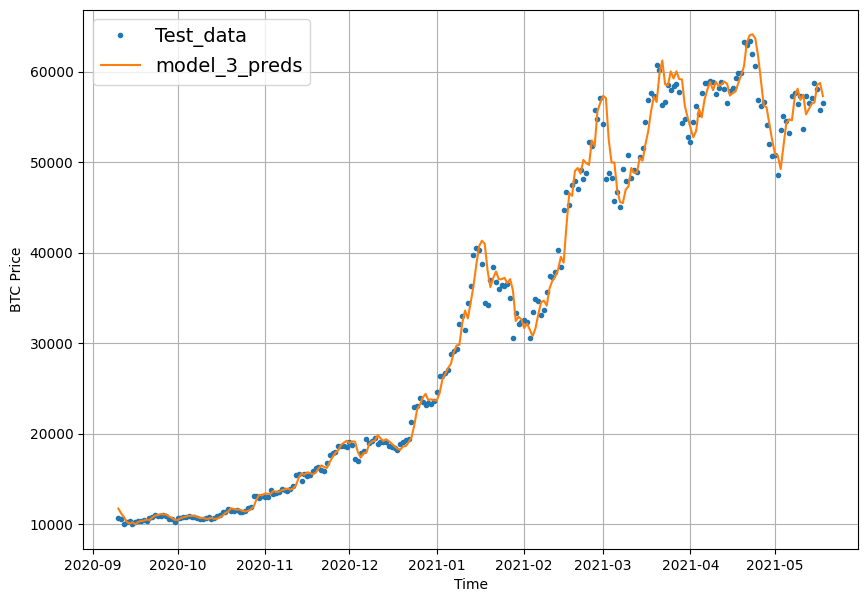

In [39]:
offset = 300
plt.figure(figsize=(10, 7))
# Plot model_3_preds by aggregating them (note: this condenses information so the preds will look fruther ahead than the test data)
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=test_labels[:, 0], 
                 start=offset, 
                 label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=tf.reduce_mean(model_3_preds, axis=1), 
                 format="-",
                 start=offset, 
                 label="model_3_preds")
plt.savefig('../data/images/experiments/plot_model_3.png')
mlflow.log_artifact('../data/images/experiments/plot_model_3.png')
mlflow.end_run()

# Which models is performing best so far?

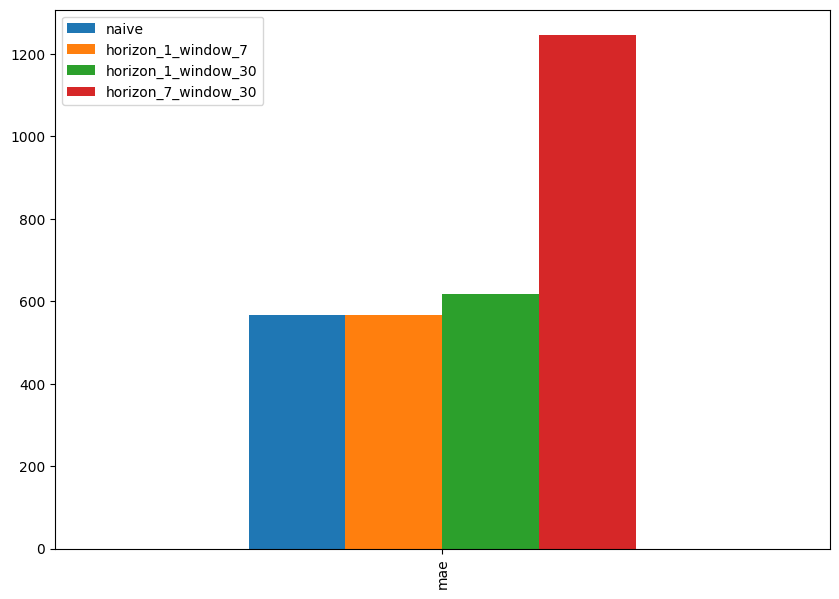

In [40]:
pd.DataFrame({"naive": naive_results["mae"], 
              "horizon_1_window_7": model_1_results["mae"], 
              "horizon_1_window_30": model_2_results["mae"], 
              "horizon_7_window_30": model_3_results["mae"]},
             index=["mae"]).plot(figsize=(10, 7), kind="bar");

Model 1 looks to perform better. From now on, we should keep using `HORIZON=1` and `WINDOW_SIZE=7`.

# Model 4: Conv1D

In [41]:
HORIZON = 1 # predict next day
WINDOW_SIZE = 7 # use previous week worth of data

In [42]:
# Create windowed dataset
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)

In [43]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(
    windows=full_windows,
    labels=full_labels)

In [44]:
model_4 = tf.keras.Sequential([
    Lambda(lambda x: tf.expand_dims(x, axis=1)),
    Conv1D(
        filters=128,
        kernel_size=5,
        padding='causal',
        activation='relu'
    ),
    Dense(HORIZON)
], name='model_4_Conv1D')

model_4.compile(loss='mae',
                optimizer=Adam())

In [45]:
with mlflow.start_run():
    
    run_name = 'model_4_conv1D'
    mlflow.set_tag('mlflow.runName', run_name)
    mlflow.tensorflow.autolog()
    
    model_4.fit(
        train_windows,
        train_labels,
        epochs=100,
        batch_size=128,
        verbose=0,
        validation_data=(test_windows, test_labels),
        callbacks=[create_model_checkpoint(model_name=model_4.name)]
    )

2023/10/29 13:26:42 WARNING mlflow.tensorflow: Encountered unexpected error while inferring batch size from training dataset: 'Sequential' object has no attribute '_nested_inputs'
2023/10/29 13:26:42 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/pop/Documents/Projects/BitPredict/bitpredict_system/.venv/lib/python3.10/site-packages/mlflow/tensorflow/_autolog.py:48: UserWarning: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data."


INFO:tensorflow:Assets written to: ../data/model_experiments/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_4_Conv1D/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_4_Conv1D/assets


1/1 [==============================] - 0s 66ms/step
INFO:tensorflow:Assets written to: /tmp/tmp9i7z26go/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmp9i7z26go/model/data/model/assets


# model 4 evaluation

In [46]:
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 878us/step - loss: 638.7918


638.7918090820312

In [47]:
# Load in best performing model
model_4 = tf.keras.models.load_model("../data/model_experiments/model_4_Conv1D/")
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 571.0906


571.090576171875

In [48]:
model_4.summary()

Model: "model_4_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            4608      
                                                                 
 dense_6 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 4737 (18.50 KB)
Trainable params: 4737 (18.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [49]:
# Make predictions
model_4_preds = make_preds(model_4, test_windows)

# Evaluate predictions
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_preds)
model_4_results

18/18 [==============================] - 0s 1ms/step


{'mae': 571.0906,
 'mse': 1179293.6,
 'rmse': 1085.9529,
 'mape': 2.551417,
 'mase': 1.003248}

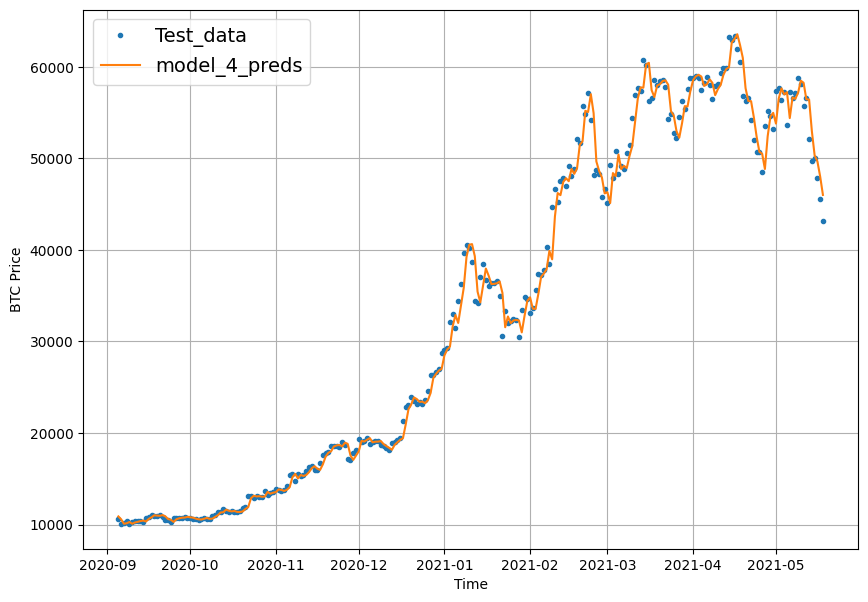

In [50]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(
    timesteps=X_test[-len(test_windows):],
    values=test_labels[:, 0],
    start=offset,
    label="Test_data")
plot_time_series(
    timesteps=X_test[-len(test_windows):],
    values=model_4_preds,
    start=offset,
    format="-",
    label="model_4_preds")
plt.savefig('../data/images/experiments/plot_model_4.png')
mlflow.log_artifact('../data/images/experiments/plot_model_4.png')
mlflow.end_run()

# Model 5: RNN (LSTM)

We can also use a recurrent neural network to model our sequential time series data. Let's reuse the same data we used for the `Conv1D` model, except this time we'll create an LSTM-cell powered RNN to model our Bitcoin data.

The `tf.keras.layers.LSTM()` layer takes a tensor with `[batch, timesteps, feature]` dimensions. the `batch` dimension gets taken care of for us but our data is currently only has the `feature` dimension `(WINDOW_SIZE)`.

To fix this, just like we did with the `Conv1D` model, we can use a `tf.keras.layers.Lambda()` layer to adjust the shape of our input tensors to the LSTM layer.



In [51]:
tf.random.set_seed(42)

inputs = Input(shape=(WINDOW_SIZE))

x = Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
X = LSTM(128, activation='relu')(x)
x = LSTM(128, activation='relu')(x)
x = Dense(32, activation='relu')(x)

output = Dense(HORIZON)(x)

model_5 = tf.keras.Model(
    inputs=inputs,
    outputs=output,
    name='model_5_LSTM'
)

model_5.compile(
    loss='mae',
    optimizer=Adam()
)

In [52]:
with mlflow.start_run():
    
    run_name = 'model_5_LSTM'
    mlflow.set_tag('mlflow.runName', run_name)
    mlflow.tensorflow.autolog()
    
    model_5.fit(
        x=train_windows,
        y=train_labels,
        epochs=100,
        verbose=0,
        batch_size=128,
        validation_data=(test_windows, test_labels),
        callbacks=[create_model_checkpoint(model_name=model_5.name)]
    )

INFO:tensorflow:Assets written to: ../data/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_5_LSTM/assets
2023/10/29 13:28:14 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: tuple index out of range
2023/10/29 13:28:14 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /tmp/tmp4nup2euh/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmp4nup2euh/model/data/model/assets


## model 5 evaluation

In [53]:
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 623.4767


623.4766845703125

In [54]:
model_3 = tf.keras.models.load_model("../data/model_experiments/model_5_LSTM/")
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 582.5734


582.5734252929688

In [55]:
model_5_preds = make_preds(model_5,
                           input_data=test_windows)

model_5_results = evaluate_tf_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_5_preds)
model_5_results

18/18 [==============================] - 0s 2ms/step


{'mae': 623.4768,
 'mse': 1297760.0,
 'rmse': 1139.1927,
 'mape': 2.8117123,
 'mase': 1.0952761}

# Make a multivariate time series

All our models have been trained on a single variable (the historical price of Bitcoin). If predicting the price of Bitcoin using the price of Bitcoin hasn't worked out very well, maybe giving our model more information may help. Would be great if we've passed our model something related to Bitcoin.

For this information, we are going to add the [Bitcoin block reward size](https://www.investopedia.com/terms/b/block-reward.asp) that stands for the number of Bitcoin someone receives from mining a Bitcoin block. At its inception, the Bitcoin block reward size was 50, but every four years or so, the Bitcoin block reward halves. Let's encode this information into our time series data and see if it helps a model's performance.

🔑 **Note**: Adding an extra feature to our dataset such as the Bitcoin block reward size will take our data from univariate (only the historical price of Bitcoin) to **multivariate** (the price of Bitcoin as well as the block reward size).

First, we'll need to create variables for the different block reward sizes as well as the dates they came into play.

The following block rewards and dates were sourced from [CMC Markets](cmcmarkets.com).

| Bitcoin Block Reward | Start Date |
|---|---
| 50 BTC | 3 January 2009 |
| 25 BTC | 28 November 2012 |
| 12.5 BTC | 9 July 2016 |
| 6.25 BTC | 11 May 2020 |
| 3.125 BTC | May 2024 (estimated) |
| 1.5625 BTC | May 2028 (estimated) |
| 0.78125 BTC | May 2032 (estimated) |

🔑 **Note**: Since our Bitcoin historical data starts from 01 October 2013, none of the timesteps in our multivariate time series will have a block reward of 50.

In [56]:
block_reward_1 = 50
block_reward_2 = 25
block_reward_3 = 12.5
block_reward_4 = 6.5


block_reward_2_datetime = np.datetime64('2012-11-28')
block_reward_3_datetime = np.datetime64('2016-07-09')
block_reward_4_datetime = np.datetime64('2020-05-11')

We're going to get the days (indexes) for different block reward values. his is important because if we're going to use multiple variables for our time series, they have to the same frequency as our original variable. For example, if our Bitcoin prices are daily, we need the block reward values to be daily as well.

🔑 **Note**: For using multiple variables, make sure they're the same frequency as each other. If your variables aren't at the same frequency (e.g. Bitcoin prices are daily but block rewards are weekly), you may need to transform them in a way that they can be used with your model.

In [57]:
# Get date indexes for when to add in different block dates
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days

Now we can add another feature to our dataset `block_reward` (this gets lower over time so it may lead to increasing prices of Bitcoin).

In [58]:
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4

In [59]:
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25


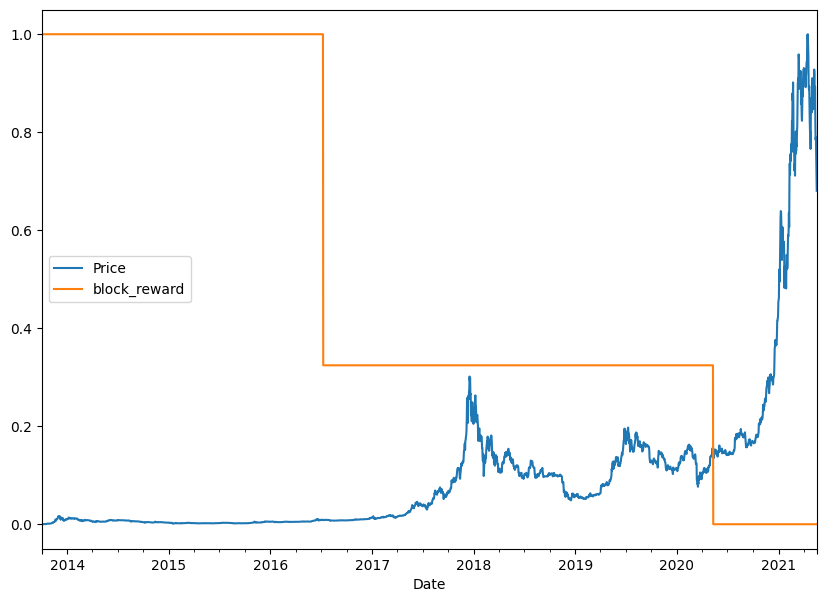

In [60]:
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]), # we need to scale the data first
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10, 7));

## Making a windowed dataset with pandas

Previously, we used some custom made functions to window our univariate time series. However, since we've just added another variable to our dataset, these functions won't work. Since our data is in a pandas DataFrame, we can leverage the `pandas.DataFrame.shift()` method to create a windowed multivariate time series.

In [61]:
# Setup dataset hyperparameters
HORIZON = 1
WINDOW_SIZE = 7

In [62]:


# Make a copy of the Bitcoin historical data with block reward feature
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE): # Shift values for each step in WINDOW_SIZE
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)

In [63]:
bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


In [64]:
# Let's create X & y, remove the NaN's and convert to float32 to prevent TensorFlow errors 
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32) 
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)

In [65]:
# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]

# Model 6: Dense (multivariate time series)

In [66]:
tf.random.set_seed(42)

model_6 = tf.keras.Sequential(
    [
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(HORIZON)
    ], name='model_6_dense_multivariate'
)

model_6.compile(
    loss='mae',
    optimizer=Adam()
)

In [67]:
with mlflow.start_run():
    
    run_name='model_6_dense_multivariate'
    mlflow.set_tag('mlflow.runName', run_name)
    mlflow.tensorflow.autolog()
    
    model_6.fit(
        X_train,
        y_train,
        epochs=100,
        batch_size=128,
        verbose=0,
        validation_data=(X_test, y_test),
        callbacks=[create_model_checkpoint(model_name=model_6.name)]
    )

2023/10/29 13:28:22 WARNING mlflow.tensorflow: Encountered unexpected error while inferring batch size from training dataset: 'Sequential' object has no attribute '_nested_inputs'
2023/10/29 13:28:22 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'pandas.core.frame.DataFrame'>. Dataset logging skipped.
2023/10/29 13:28:22 WARNING mlflow.tensorflow: Failed to log training dataset information to MLflow Tracking. Reason: 'DataFrame' object has no attribute 'flatten'
2023/10/29 13:28:23 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/pop/Documents/Projects/BitPredict/bitpredict_system/.venv/lib/python3.10/site-packages/mlflow/tensorflow/_autolog.py:48: UserWarning: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data."


INFO:tensorflow:Assets written to: ../data/model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/model_6_dense_multivariate/assets
2023/10/29 13:28:40 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: Cannot log input example or model signature for input with type <class 'pandas.core.frame.DataFrame'>. TensorFlow Keras autologging can only log input examples and model signatures for the following input types: numpy.ndarray, dict[string -> numpy.ndarray], tensorflow.keras.utils.Sequence, and tensorflow.data.Dataset (TensorFlow >= 2.1.0 required)
2023/10/29 13:28:40 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /tmp/tmpka94rmw5/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpka94rmw5/model/data/model/assets


## model 6 evaluation

In [68]:
model_6.summary()

Model: "model_6_dense_multivariate"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 128)               1152      
                                                                 
 dense_10 (Dense)            (None, 128)               16512     
                                                                 
 dense_11 (Dense)            (None, 128)               16512     
                                                                 
 dense_12 (Dense)            (None, 128)               16512     
                                                                 
 dense_13 (Dense)            (None, 1)                 129       
                                                                 
Total params: 50817 (198.50 KB)
Trainable params: 50817 (198.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [69]:
model_6 = tf.keras.models.load_model(
    '../data/model_experiments/model_6_dense_multivariate'
    )

In [70]:
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 1ms/step - loss: 567.6869


567.6868896484375

In [71]:
# Make predictions on multivariate data
model_6_preds = tf.squeeze(model_6.predict(X_test))

18/18 [==============================] - 0s 976us/step


In [72]:
# Evaluate preds
model_6_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_6_preds)
model_6_results

{'mae': 567.6868,
 'mse': 1156438.2,
 'rmse': 1075.3782,
 'mape': 2.5615537,
 'mase': 0.9972685}

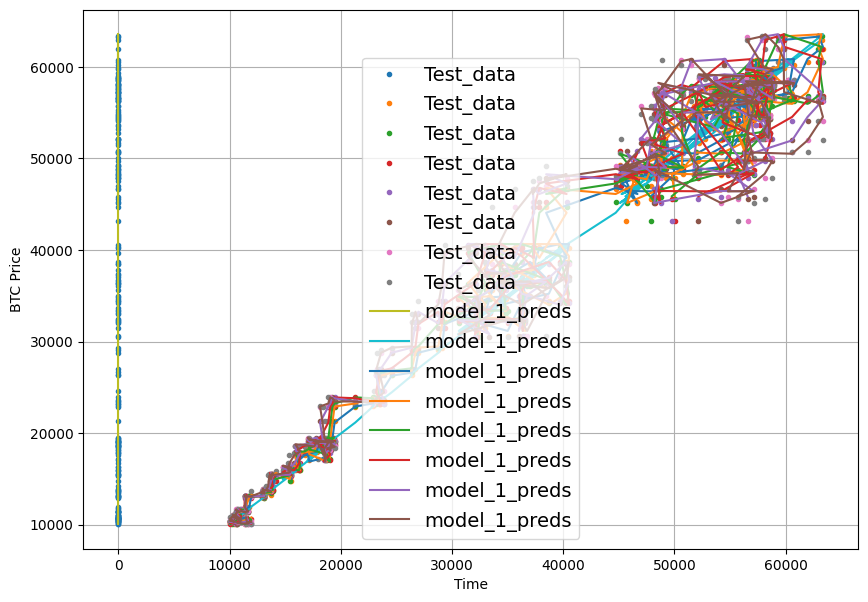

In [73]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(
    timesteps=X_test[-len(test_windows):],
    values=test_labels[:, 0],
    start=offset,
    label="Test_data")
plot_time_series(
    timesteps=X_test[-len(test_windows):],
    values=model_1_preds,
    start=offset,
    format="-",
    label="model_1_preds")
plt.savefig('../data/images/experiments/plot_model_6.png')
mlflow.log_artifact('../data/images/experiments/plot_model_6.png')
mlflow.end_run()

# Model 7: N-BEATS algorithm

So far we've tried a bunch of smaller models, models with only a couple of layers.

But one of the best ways to improve a model's performance is to increase the number of layers in it.

That's exactly what the N-BEATS [(Neural Basis Expansion Analysis for Interpretable Time Series Forecasting)](https://arxiv.org/pdf/1905.10437.pdf) algorithm does.

The N-BEATS algorithm focuses on univariate time series problems and achieved state-of-the-art performance in the winner of the [M4 competition](https://www.sciencedirect.com/science/article/pii/S0169207019301128) (a forecasting competition).

## Preparing data for N-BEATS algorithm using `tf.data`

In [74]:
HORIZON = 1
WINDOW_SIZE = 7

In [75]:
# Add windowed columns
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=i+1)
bitcoin_prices_nbeats.dropna().head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500
2013-10-10,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483
2013-10-11,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466
2013-10-12,125.92750,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866


In [76]:
# Make features and labels
X = bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
y = bitcoin_prices_nbeats.dropna()["Price"]

# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

Now let's convert them into TensorFlow `tf.data.Dataset` to ensure they run as fast as possible whilst training.

We'll do this by:

1. Turning the arrays in tensor Datasets using `tf.data.Dataset.from_tensor_slices()`

2. Combine the labels and features tensors into a Dataset using `tf.data.Dataset.zip()`

3. Batch and prefetch the Datasets using `batch()` and `prefetch()`

📖 **Resource**: For more on building highly performant TensorFlow data pipelines, I'd recommend reading through the [Better performance with the tf.data API](https://www.tensorflow.org/guide/data_performance) guide.

In [77]:
# 1. Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# 2. Combine features & labels
train_dataset = tf.data.Dataset.zip((
    train_features_dataset,
    train_labels_dataset
    ))
test_dataset = tf.data.Dataset.zip((
    test_features_dataset,
    test_labels_dataset))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

## Set-up hyperparameters for N-BEATS algorithm

📖 **Resource**: The following hyperparameters are taken from Figure 1 and Table 18/Appendix D of the [N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf).

In [78]:
# Values from N-BEATS paper Figure 1 and Table 18/Appendix D
N_EPOCHS = 5000 # called "Iterations" in Table 18
N_NEURONS = 512 # called "Width" in Table 18
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON # called "Lookback" in Table 18
THETA_SIZE = INPUT_SIZE + HORIZON

## Getting ready for residual connections

Before we create the N-BEATS model, there are two layers to go through which play a large roll in the architecture.

They're what make N-BEATS double residual stacking (section 3.2 of the [N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf)) possible:

- `tf.keras.layers.subtract(inputs)` - subtracts list of input tensors from each other.
- `tf.keras.layers.add(inputs)` - adds list of input tensors to each other.

In [79]:
# Make tensors
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

# Subtract
subtracted = layers.subtract([tensor_1, tensor_2])

# Add
added = layers.add([tensor_1, tensor_2])

Both of these layer functions are straight-forward, subtract or add together their inputs. And as mentioned before, they're what powers N-BEATS double residual stacking.

The power of residual stacking or residual connections was revealed in [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385) where the authors were able to build a deeper but less complex neural network (this is what introduced the popular [ResNet architecture](https://en.wikipedia.org/wiki/Residual_neural_network)) than previous attempts.

This deeper neural network led to state of the art results on the ImageNet challenge in 2015 and different versions of **residual connections** have been present in deep learning ever since.

A residual connection (also called skip connections) involves a deeper neural network layer receiving the outputs as well as the inputs of a shallower neural network layer.

In the case of N-BEATS, the architecture uses residual connections which:

- Subtract the backcast outputs from a previous block from the backcast inputs to the current block.

- Add the forecast outputs from all blocks together in a stack.

In [80]:
tf.random.set_seed(42)

nbeats_block_layer = NBeatsBlock(
    input_size=INPUT_SIZE,
    theta_size=THETA_SIZE,
    horizon=HORIZON,
    n_neurons=N_NEURONS,
    n_layers=N_LAYERS,
    name='InitialBlock'
)

stack_input = Input(shape=(INPUT_SIZE), name='stack_input')

backcast, forecast = nbeats_block_layer(stack_input)

residuals = subtract(
    [stack_input, backcast],
    name=f'subtract_00')

for i, _ in enumerate(range(N_STACKS-1)):
    
    backcast, block_forecast = NBeatsBlock(
        input_size=INPUT_SIZE,
        theta_size=THETA_SIZE,
        horizon=HORIZON,
        n_neurons=N_NEURONS,
        n_layers=N_LAYERS,
        name=f'NBeatsBlock_{i}'
    )(residuals)
    
    residuals = subtract(
        [residuals, backcast],
        name=f'subtract_{i}')
    forecast = add(
        [forecast, block_forecast],
        name=f'add_{i}')

model_7 = tf.keras.Model(
    inputs=stack_input,
    outputs=forecast,
    name='model_7_N-BEATS'
)

model_7.compile(
    loss='mae',
    optimizer=Adam(learning_rate=0.001),
    metrics=['mae', 'mse']
)

In [81]:
with mlflow.start_run():
    
    run_name = 'model_7_N-BEATS',
    mlflow.set_tag('mlflow.runName', run_name)
    mlflow.tensorflow.autolog()
    
    model_7.fit(
        train_dataset,
        epochs=N_EPOCHS,
        validation_data=test_dataset,
        verbose=0,
        callbacks=[
            EarlyStopping(
                monitor='val_loss',
                patience=200,
                restore_best_weights=True
            ),
            ReduceLROnPlateau(
                monitor='val_loss',
                patience=100,
                verbose=1
            )
        ]
    )


Epoch 255: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 355: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
1/1 [==============================] - 1s 1s/step
INFO:tensorflow:Assets written to: /tmp/tmpzazozm3k/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpzazozm3k/model/data/model/assets


## model 7 evaluation

In [82]:
model_7.summary()

Model: "model_7_N-BEATS"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 stack_input (InputLayer)    [(None, 7)]                  0         []                            
                                                                                                  
 InitialBlock (NBeatsBlock)  ((None, 7),                  796168    ['stack_input[0][0]']         
                              (None, 1))                                                          
                                                                                                  
 subtract_00 (Subtract)      (None, 7)                    0         ['stack_input[0][0]',         
                                                                     'InitialBlock[0][0]']        
                                                                                    

                                                                                                  
 subtract_23 (Subtract)      (None, 7)                    0         ['subtract_22[0][0]',         
                                                                     'NBeatsBlock_23[0][0]']      
                                                                                                  
 add_19 (Add)                (None, 1)                    0         ['add_18[0][0]',              
                                                                     'NBeatsBlock_19[0][1]']      
                                                                                                  
 NBeatsBlock_24 (NBeatsBloc  ((None, 7),                  796168    ['subtract_23[0][0]']         
 k)                           (None, 1))                                                          
                                                                                                  
 add_20 (A

In [83]:
model_1.evaluate(test_windows, test_labels)

 1/18 [>.............................] - ETA: 0s - loss: 153.5730 - mae: 153.5730

18/18 [==============================] - 0s 1ms/step - loss: 567.3574 - mae: 567.3574


[567.357421875, 567.357421875]

In [84]:
# Make predictions with N-BEATS model
model_7_preds = make_preds(model_7, test_dataset)
model_7_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_7_preds)
model_7_results

1/1 [==============================] - 1s 1s/step


{'mae': 579.37195,
 'mse': 1172870.5,
 'rmse': 1082.9915,
 'mape': 2.6538136,
 'mase': 1.017796}

## plotting N-BEATS architecture

In [85]:
plot_model(model_7, to_file='../data/images/experiments/plot_model_7.png')
mlflow.log_artifact('../data/images/experiments/plot_model_7.png')
mlflow.end_run()

# Model 8: Ensemble model

In [86]:
with mlflow.start_run():
    
    run_name = 'model_8_ensemble'
    mlflow.set_tag('mlflow.runName', run_name)
    mlflow.tensorflow.autolog()

    ensemble_models = get_ensemble_models(
        train_data=train_dataset,
        test_data=test_dataset,
        horizon=HORIZON,
        num_iter=5,
        num_epochs=1000)

2023/10/29 13:38:43 WARNING mlflow.tensorflow: Encountered unexpected error while inferring batch size from training dataset: 'Sequential' object has no attribute '_nested_inputs'


2023/10/29 13:38:44 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/pop/Documents/Projects/BitPredict/bitpredict_system/.venv/lib/python3.10/site-packages/mlflow/tensorflow/_autolog.py:48: UserWarning: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data."


Optimizing model by reducing: mae for 1000 epochs, model number: 0

Epoch 787: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
1/1 [==============================] - 0s 49ms/step
INFO:tensorflow:Assets written to: /tmp/tmpv1e4kaig/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpv1e4kaig/model/data/model/assets
2023/10/29 13:40:00 WARNING mlflow.tensorflow: Encountered unexpected error while inferring batch size from training dataset: 'Sequential' object has no attribute '_nested_inputs'
2023/10/29 13:40:00 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/pop/Documents/Projects/BitPredict/bitpredict_system/.venv/lib/python3.10/site-packages/mlflow/tensorflow/_autolog.py:48: UserWarning: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data."


Optimizing model by reducing: mse for 1000 epochs, model number: 0

Epoch 500: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 600: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.


1/1 [==============================] - 0s 53ms/step
INFO:tensorflow:Assets written to: /tmp/tmpq6v2ys_e/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpq6v2ys_e/model/data/model/assets
2023/10/29 13:40:48 WARNING mlflow.tensorflow: Encountered unexpected error while inferring batch size from training dataset: 'Sequential' object has no attribute '_nested_inputs'
2023/10/29 13:40:48 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/pop/Documents/Projects/BitPredict/bitpredict_system/.venv/lib/python3.10/site-packages/mlflow/tensorflow/_autolog.py:48: UserWarning: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data."


Optimizing model by reducing: mape for 1000 epochs, model number: 0

Epoch 183: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 645: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 745: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.


1/1 [==============================] - 0s 50ms/step
INFO:tensorflow:Assets written to: /tmp/tmptn6coza_/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmptn6coza_/model/data/model/assets
2023/10/29 13:41:47 WARNING mlflow.tensorflow: Encountered unexpected error while inferring batch size from training dataset: 'Sequential' object has no attribute '_nested_inputs'
2023/10/29 13:41:47 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/pop/Documents/Projects/BitPredict/bitpredict_system/.venv/lib/python3.10/site-packages/mlflow/tensorflow/_autolog.py:48: UserWarning: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data."


Optimizing model by reducing: mae for 1000 epochs, model number: 1

Epoch 502: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 671: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 771: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
1/1 [==============================] - 0s 48ms/step
INFO:tensorflow:Assets written to: /tmp/tmpcjnxda_7/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpcjnxda_7/model/data/model/assets
2023/10/29 13:42:48 WARNING mlflow.tensorflow: Encountered unexpected error while inferring batch size from training dataset: 'Sequential' object has no attribute '_nested_inputs'
2023/10/29 13:42:48 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/pop/Documents/Projects/BitPredict/bitpredict_system/.venv/lib/python3.10/site-packages/mlflow/tensorflow/_autolog.py:48: UserWarning: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data."


Optimizing model by reducing: mse for 1000 epochs, model number: 1

Epoch 268: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 368: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
1/1 [==============================] - 0s 49ms/step
INFO:tensorflow:Assets written to: /tmp/tmphpdmgfm9/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmphpdmgfm9/model/data/model/assets
2023/10/29 13:43:19 WARNING mlflow.tensorflow: Encountered unexpected error while inferring batch size from training dataset: 'Sequential' object has no attribute '_nested_inputs'
2023/10/29 13:43:19 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/pop/Documents/Projects/BitPredict/bitpredict_system/.venv/lib/python3.10/site-packages/mlflow/tensorflow/_autolog.py:48: UserWarning: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data."


Optimizing model by reducing: mape for 1000 epochs, model number: 1

Epoch 204: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 635: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 735: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
1/1 [==============================] - 0s 47ms/step
INFO:tensorflow:Assets written to: /tmp/tmptfj3pdbd/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmptfj3pdbd/model/data/model/assets
2023/10/29 13:44:17 WARNING mlflow.tensorflow: Encountered unexpected error while inferring batch size from training dataset: 'Sequential' object has no attribute '_nested_inputs'
2023/10/29 13:44:17 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/pop/Documents/Projects/BitPredict/bitpredict_system/.venv/lib/python3.10/site-packages/mlflow/tensorflow/_autolog.py:48: UserWarning: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data."


Optimizing model by reducing: mae for 1000 epochs, model number: 2

Epoch 908: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
1/1 [==============================] - 0s 56ms/step
INFO:tensorflow:Assets written to: /tmp/tmp2ffeqmp6/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmp2ffeqmp6/model/data/model/assets
2023/10/29 13:45:34 WARNING mlflow.tensorflow: Encountered unexpected error while inferring batch size from training dataset: 'Sequential' object has no attribute '_nested_inputs'
2023/10/29 13:45:34 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/pop/Documents/Projects/BitPredict/bitpredict_system/.venv/lib/python3.10/site-packages/mlflow/tensorflow/_autolog.py:48: UserWarning: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data."


Optimizing model by reducing: mse for 1000 epochs, model number: 2

Epoch 515: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 615: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
1/1 [==============================] - 0s 46ms/step
INFO:tensorflow:Assets written to: /tmp/tmpvv8e4p3_/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpvv8e4p3_/model/data/model/assets
2023/10/29 13:46:23 WARNING mlflow.tensorflow: Encountered unexpected error while inferring batch size from training dataset: 'Sequential' object has no attribute '_nested_inputs'
2023/10/29 13:46:23 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/pop/Documents/Projects/BitPredict/bitpredict_system/.venv/lib/python3.10/site-packages/mlflow/tensorflow/_autolog.py:48: UserWarning: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data."


Optimizing model by reducing: mape for 1000 epochs, model number: 2

Epoch 175: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 275: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
1/1 [==============================] - 0s 52ms/step
INFO:tensorflow:Assets written to: /tmp/tmpunhy4ik3/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpunhy4ik3/model/data/model/assets
2023/10/29 13:46:48 WARNING mlflow.tensorflow: Encountered unexpected error while inferring batch size from training dataset: 'Sequential' object has no attribute '_nested_inputs'
2023/10/29 13:46:48 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/pop/Documents/Projects/BitPredict/bitpredict_system/.venv/lib/python3.10/site-packages/mlflow/tensorflow/_autolog.py:48: UserWarning: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data."


Optimizing model by reducing: mae for 1000 epochs, model number: 3

Epoch 116: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 961: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
1/1 [==============================] - 0s 47ms/step
INFO:tensorflow:Assets written to: /tmp/tmpj6dj50l1/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpj6dj50l1/model/data/model/assets
2023/10/29 13:48:05 WARNING mlflow.tensorflow: Encountered unexpected error while inferring batch size from training dataset: 'Sequential' object has no attribute '_nested_inputs'
2023/10/29 13:48:06 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/pop/Documents/Projects/BitPredict/bitpredict_system/.venv/lib/python3.10/site-packages/mlflow/tensorflow/_autolog.py:48: UserWarning: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data."


Optimizing model by reducing: mse for 1000 epochs, model number: 3

Epoch 433: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 533: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
1/1 [==============================] - 0s 48ms/step
INFO:tensorflow:Assets written to: /tmp/tmp1ov5d9wc/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmp1ov5d9wc/model/data/model/assets
2023/10/29 13:48:49 WARNING mlflow.tensorflow: Encountered unexpected error while inferring batch size from training dataset: 'Sequential' object has no attribute '_nested_inputs'
2023/10/29 13:48:49 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/pop/Documents/Projects/BitPredict/bitpredict_system/.venv/lib/python3.10/site-packages/mlflow/tensorflow/_autolog.py:48: UserWarning: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data."


Optimizing model by reducing: mape for 1000 epochs, model number: 3

Epoch 345: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 847: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 947: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
1/1 [==============================] - 0s 45ms/step
INFO:tensorflow:Assets written to: /tmp/tmpatpafsmj/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpatpafsmj/model/data/model/assets
2023/10/29 13:50:06 WARNING mlflow.tensorflow: Encountered unexpected error while inferring batch size from training dataset: 'Sequential' object has no attribute '_nested_inputs'
2023/10/29 13:50:06 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/pop/Documents/Projects/BitPredict/bitpredict_system/.venv/lib/python3.10/site-packages/mlflow/tensorflow/_autolog.py:48: UserWarning: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data."


Optimizing model by reducing: mae for 1000 epochs, model number: 4
1/1 [==============================] - 0s 50ms/step
INFO:tensorflow:Assets written to: /tmp/tmpq3wnxi8k/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpq3wnxi8k/model/data/model/assets
2023/10/29 13:51:23 WARNING mlflow.tensorflow: Encountered unexpected error while inferring batch size from training dataset: 'Sequential' object has no attribute '_nested_inputs'
2023/10/29 13:51:23 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/pop/Documents/Projects/BitPredict/bitpredict_system/.venv/lib/python3.10/site-packages/mlflow/tensorflow/_autolog.py:48: UserWarning: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data."


Optimizing model by reducing: mse for 1000 epochs, model number: 4

Epoch 509: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 609: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
1/1 [==============================] - 0s 47ms/step
INFO:tensorflow:Assets written to: /tmp/tmpjn0vesej/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpjn0vesej/model/data/model/assets
2023/10/29 13:52:12 WARNING mlflow.tensorflow: Encountered unexpected error while inferring batch size from training dataset: 'Sequential' object has no attribute '_nested_inputs'
2023/10/29 13:52:12 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/pop/Documents/Projects/BitPredict/bitpredict_system/.venv/lib/python3.10/site-packages/mlflow/tensorflow/_autolog.py:48: UserWarning: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data."


Optimizing model by reducing: mape for 1000 epochs, model number: 4

Epoch 142: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 311: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 411: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
1/1 [==============================] - 0s 63ms/step
INFO:tensorflow:Assets written to: /tmp/tmpf40ei88b/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpf40ei88b/model/data/model/assets


## Making predictions with an ensemble model

In [87]:
ensemble_preds = make_ensemble_preds(
    ensemble_models=ensemble_models,
    data=test_dataset
)

ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=np.median(ensemble_preds, axis=0))

ensemble_results

1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 44ms/step


{'mae': 569.4558,
 'mse': 1146703.0,
 'rmse': 1070.8422,
 'mape': 2.5762365,
 'mase': 1.0003761}

## Plotting the prediction intervals (uncertainty estimates) of our ensemble

📖 **Resource(s):**

- The steps we're about to take have been inspired by the Machine Learning Mastery blog post [*Prediction Intervals for Deep Learning Neural Networks*](https://machinelearningmastery.com/prediction-intervals-for-deep-learning-neural-networks/). Check out the post for more options to measure uncertainty with neural networks.

- For an example of uncertainty estimates being used in the wild, I'd also refer to Uber's Engineering Uncertainty Estimation in Neural Networks for [*Time Series Prediction at Uber*](https://eng.uber.com/neural-networks-uncertainty-estimation/) blog post.

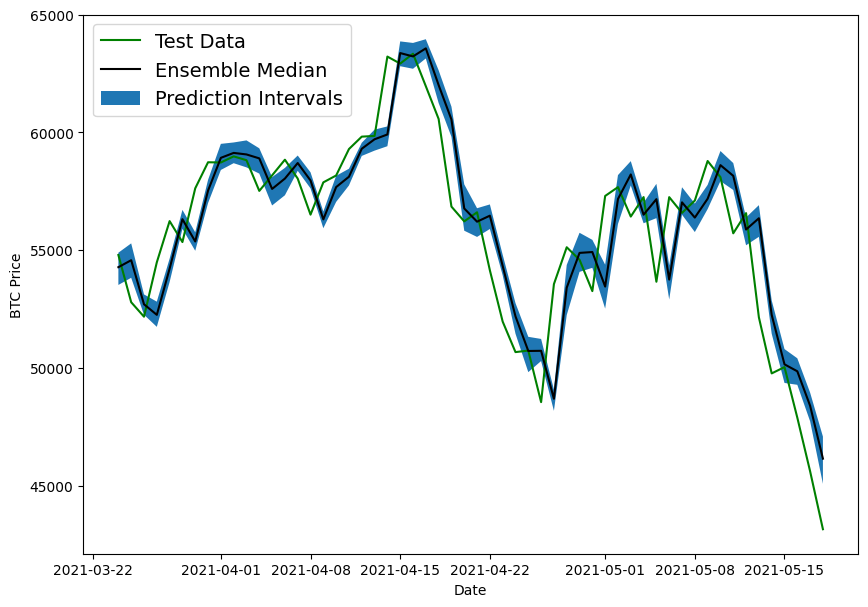

In [88]:
# Get the upper and lower bounds of the 95% 
lower, upper = get_upper_lower(preds=ensemble_preds)

ensemble_median = np.median(ensemble_preds, axis=0)

offset=500
plt.figure(figsize=(10, 7))
plt.plot(X_test.index[offset:], y_test[offset:], "g", label="Test Data")
plt.plot(X_test.index[offset:], ensemble_median[offset:], "k-", label="Ensemble Median")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.fill_between(X_test.index[offset:], 
                 (lower)[offset:], 
                 (upper)[offset:], label="Prediction Intervals")
plt.legend(loc="upper left", fontsize=14);
plt.savefig('../data/images/experiments/plot_model_8.png')
mlflow.log_artifact('../data/images/experiments/plot_model_8.png')
mlflow.end_run()

# Model 9: Full historical data model

In [89]:
X_all = bitcoin_prices_windowed.drop(
    ["Price", "block_reward"],
    axis=1).dropna().to_numpy()
y_all = bitcoin_prices_windowed.dropna()["Price"].to_numpy()

Let's turn them into performance optimized TensorFlow Datasets by:

1. Turning `X_all` and `y_all` into tensor Datasets using `tf.data.Dataset.from_tensor_slices()`.
2. Combining the features and labels into a Dataset tuple using `tf.data.Dataset.zip()`.
3. Batch and prefetch the data using `tf.data.Dataset.batch()` and `tf.data.Dataset.prefetch()` respectively.

In [90]:
# 1. Turn X and y into tensor Datasets
features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

# 2. Combine features & labels
dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [91]:
tf.random.set_seed(42)

model_9 = tf.keras.models.Sequential(
    [
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dense(HORIZON)
    ], name='model_9_full_historical_data'
)

model_9.compile(
    loss='mae',
    optimizer=Adam()
)

In [92]:
with mlflow.start_run():
    
    run_name = 'model_9_full_historical_data'
    mlflow.set_tag('mlflow.runName', run_name)
    mlflow.tensorflow.autolog()
    
    model_9.fit(
        dataset_all,
        epochs=100,
        verbose=0,
        callbacks=[create_model_checkpoint(model_name=model_9.name)]
    )

2023/10/29 13:52:48 WARNING mlflow.tensorflow: Encountered unexpected error while inferring batch size from training dataset: 'Sequential' object has no attribute '_nested_inputs'
2023/10/29 13:52:49 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/pop/Documents/Projects/BitPredict/bitpredict_system/.venv/lib/python3.10/site-packages/mlflow/tensorflow/_autolog.py:48: UserWarning: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data."


1/1 [==============================] - 0s 62ms/step
INFO:tensorflow:Assets written to: /tmp/tmpvbfa72mq/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpvbfa72mq/model/data/model/assets


## Making predictions on the future

In [93]:
INTO_FUTURE=14

In [94]:
future_forecast = make_future_forecast(values=y_all,
                                       model=model_9,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

1/1 [==============================] - 0s 54ms/step
Predicting on: 
 [56573.5554719  52147.82118698 49764.1320816  50032.69313676
 47885.62525472 45604.61575361 43144.47129086] -> Prediction: 41924.359375

1/1 [==============================] - 0s 20ms/step
Predicting on: 
 [52147.82118698 49764.1320816  50032.69313676 47885.62525472
 45604.61575361 43144.47129086 41924.359375  ] -> Prediction: 39747.15625

1/1 [==============================] - 0s 19ms/step
Predicting on: 
 [49764.1320816  50032.69313676 47885.62525472 45604.61575361
 43144.47129086 41924.359375   39747.15625   ] -> Prediction: 38180.23828125

1/1 [==============================] - 0s 19ms/step
Predicting on: 
 [50032.69313676 47885.62525472 45604.61575361 43144.47129086
 41924.359375   39747.15625    38180.23828125] -> Prediction: 37411.375

1/1 [==============================] - 0s 18ms/step
Predicting on: 
 [47885.62525472 45604.61575361 43144.47129086 41924.359375
 39747.15625    38180.23828125 37411.375     ] -> 

## Plot future forecasts

In [95]:
timesteps = []
btc_price = []
with open("../data/raw/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", "r") as f:
  csv_reader = csv.reader(f, delimiter=",") # read in the target CSV
  next(csv_reader) # skip first line (this gets rid of the column titles)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1], "%Y-%m-%d")) # get the dates as dates (not strings), strptime = string parse time
    btc_price.append(float(line[2]))

In [96]:
# Last timestep of timesteps (currently in np.datetime64 format)
last_timestep = bitcoin_prices.index[-1]

# Get next two weeks of timesteps
next_time_steps = get_future_dates(start_date=last_timestep, 
                                   into_future=INTO_FUTURE)

# Insert last timestep/final price so the graph doesn't look messed
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, btc_price[-1])

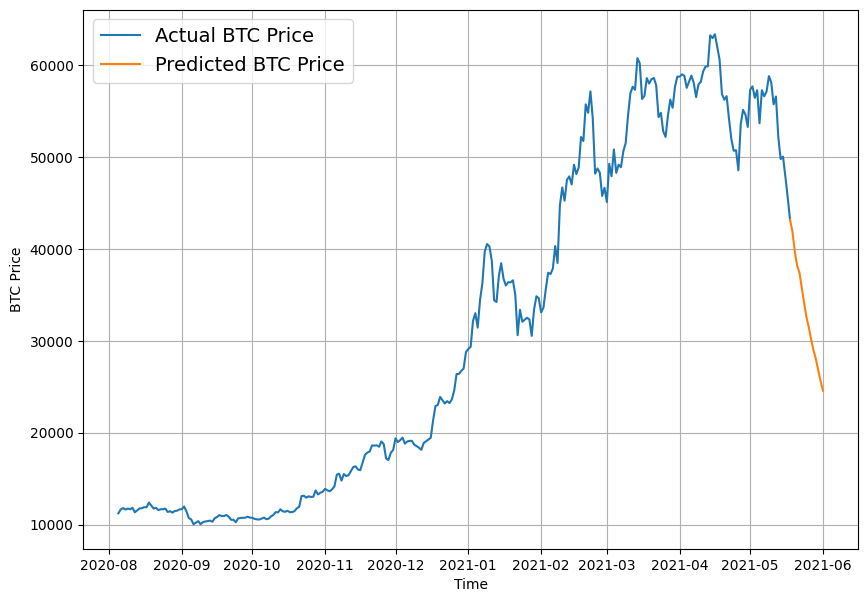

In [97]:
# Plot future price predictions of Bitcoin
plt.figure(figsize=(10, 7))
plot_time_series(
    bitcoin_prices.index,
    btc_price,
    start=2500,
    format="-",
    label="Actual BTC Price")
plot_time_series(
    next_time_steps,
    future_forecast,
    format="-",
    label="Predicted BTC Price")

plt.savefig('../data/images/experiments/plot_model_9.png')
mlflow.log_artifact('../data/images/experiments/plot_model_9.png')
mlflow.end_run()

🔑 **Note**: A reminder, the predictions we've made here are not financial advice. And by now, you should be well aware of just how poor machine learning models can be at forecasting values in an open system - anyone promising you a model which can "beat the market" is likely trying to scam you, oblivious to their errors or very lucky.

# Model 10: Turkey problem

In [98]:
# Let's introduce a Turkey problem to our BTC data (price BTC falls 100x in one day)
btc_price_turkey = btc_price.copy()
btc_price_turkey[-1] = btc_price_turkey[-1] / 100

# Get the timesteps for the turkey problem 
btc_timesteps_turkey = np.array(bitcoin_prices.index)

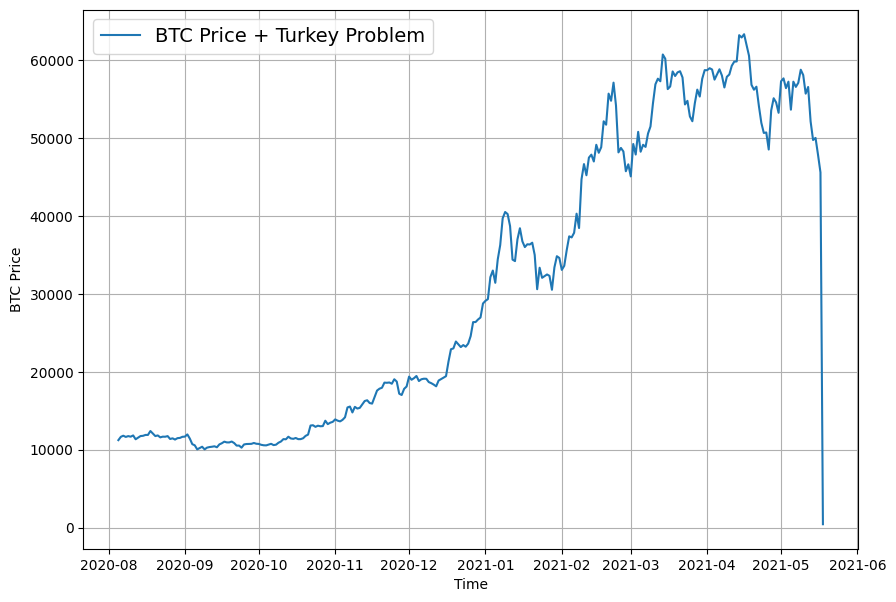

In [99]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=btc_timesteps_turkey, 
                 values=btc_price_turkey, 
                 format="-", 
                 label="BTC Price + Turkey Problem", 
                 start=2500)

In [100]:
# Create train and test sets for turkey problem data
full_windows, full_labels = make_windows(np.array(btc_price_turkey), window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

X_train, X_test, y_train, y_test = make_train_test_splits(full_windows, full_labels)
len(X_train), len(X_test), len(y_train), len(y_test)

(2224, 556, 2224, 556)

## Building turkey model to predict on turkey data

In [101]:
# Clone model 1 architecture for turkey model and fit the turkey model on the turkey data
turkey_model = tf.keras.models.clone_model(model_1)
turkey_model._name = "Turkey_Model"
turkey_model.compile(loss="mae",
                     optimizer=Adam())

In [102]:
with mlflow.start_run():
    
    run_name = 'model_10_turkey',
    mlflow.set_tag('mlflow.runName', run_name)
    mlflow.tensorflow.autolog()
    
    turkey_model.fit(
        X_train,
        y_train,
        epochs=100,
        verbose=0,
        validation_data=(X_test, y_test),
        callbacks=[create_model_checkpoint(turkey_model.name)])

INFO:tensorflow:Assets written to: ../data/model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/Turkey_Model/assets


INFO:tensorflow:Assets written to: ../data/model_experiments/Turkey_Model/assets


1/1 [==============================] - 0s 45ms/step
INFO:tensorflow:Assets written to: /tmp/tmpxxomx0qo/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpxxomx0qo/model/data/model/assets


# Turkey model evaluation

In [103]:
turkey_model.summary()

Model: "Turkey_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1024      
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1153 (4.50 KB)
Trainable params: 1153 (4.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [104]:
# Evaluate turkey model on test data
turkey_model.evaluate(X_test, y_test)

18/18 [==============================] - 0s 1ms/step - loss: 724.5437


724.543701171875

In [105]:
# Load best model and evaluate on test data
turkey_model = tf.keras.models.load_model("../data/model_experiments/Turkey_Model/")
turkey_model.evaluate(X_test, y_test)

18/18 [==============================] - 0s 1ms/step - loss: 642.3993


642.3992919921875

In [106]:
# Make predictions with Turkey model
turkey_preds = make_preds(turkey_model, X_test)

# Evaluate turkey preds
turkey_results = evaluate_tf_preds(y_true=y_test,
                                y_pred=turkey_preds)
turkey_results

18/18 [==============================] - 0s 887us/step


{'mae': 17120.654,
 'mse': 613775300.0,
 'rmse': 23696.49,
 'mape': 121.23451,
 'mase': 26.494267}

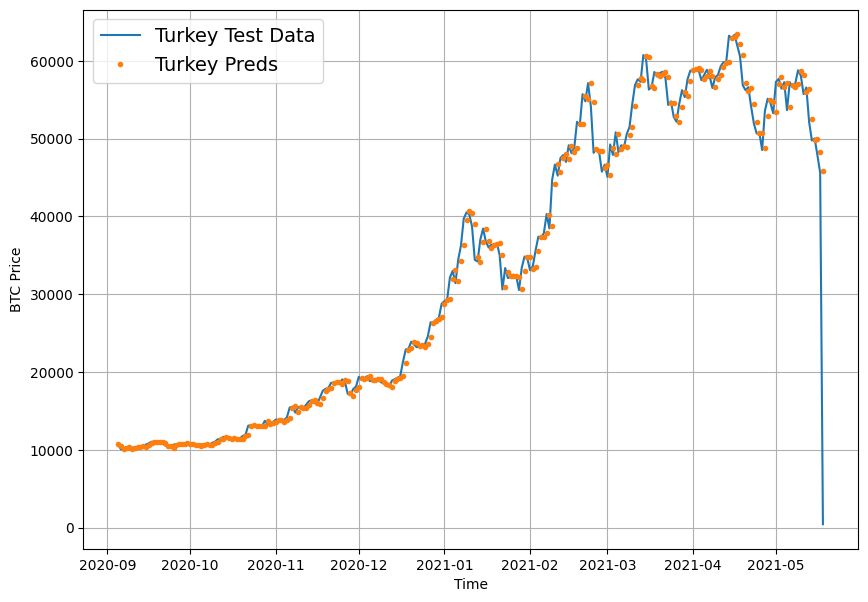

In [107]:
plt.figure(figsize=(10, 7))
# plot_time_series(timesteps=btc_timesteps_turkey[:split_size], values=btc_price_turkey[:split_size], label="Train Data")
offset=300
plot_time_series(timesteps=btc_timesteps_turkey[-len(X_test):], 
                 values=btc_price_turkey[-len(y_test):], 
                 format="-", 
                 label="Turkey Test Data", start=offset)
plot_time_series(timesteps=btc_timesteps_turkey[-len(X_test):],
                 values=turkey_preds, 
                 label="Turkey Preds", 
                 start=offset);
plt.savefig('../data/images/experiments/plot_model_10.png')
mlflow.log_artifact('../data/images/experiments/plot_model_10.png')
mlflow.end_run()

# Compare Models

In [108]:
# Compare different model results (w = window, h = horizon, e.g. w=7 means a window size of 7)
model_results = pd.DataFrame({"naive_model": naive_results,
                              "model_1_dense_w7_h1": model_1_results,
                              "model_2_dense_w30_h1": model_2_results,
                              "model_3_dense_w30_h7": model_3_results,
                              "model_4_CONV1D": model_4_results,
                              "model_5_LSTM": model_5_results,
                              "model_6_multivariate": model_6_results,
                              "model_8_NBEATs": model_7_results,
                              "model_9_ensemble": ensemble_results,
                              "model_10_turkey": turkey_results}).T
model_results.head(10)

,mae,mse,rmse,mape,mase
naive_model,567.980225,1.147547e+06,1071.236206,2.516525,0.999570
model_1_dense_w7_h1,567.357361,1.162004e+06,1077.962646,2.550650,0.996690
model_2_dense_w30_h1,617.790344,1.324576e+06,1150.902344,2.823207,1.079903
model_3_dense_w30_h7,1245.383423,5.358528e+06,1432.111938,5.565821,2.216090
model_4_CONV1D,571.090576,1.179294e+06,1085.952881,2.551417,1.003248
model_5_LSTM,623.476807,1.297760e+06,1139.192749,2.811712,1.095276
model_6_multivariate,567.686829,1.156438e+06,1075.378174,2.561554,0.997268
model_8_NBEATs,579.371948,1.172870e+06,1082.991455,2.653814,1.017796
model_9_ensemble,569.455811,1.146703e+06,1070.842163,2.576236,1.000376
model_10_turkey,17120.654297,6.137753e+08,23696.490234,121.234512,26.494267


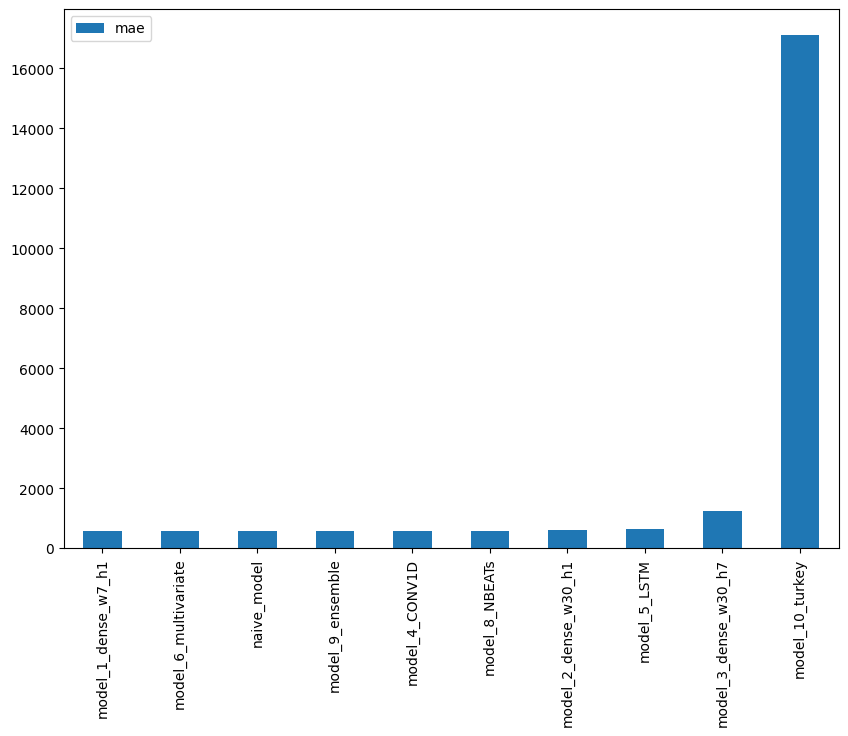

In [109]:
# Sort model results by MAE and plot them
model_results[["mae"]].sort_values(by="mae").plot(figsize=(10, 7), kind="bar");

Based on the metrics, the best model is the ensemble model. It has the lowest RMSE and MAE, which means that it is the most accurate model. It also has the highest R-squared value, which means that it is able to explain the most variance in the data.

The ensemble model is a combination of multiple other models, which gives it a number of advantages. First, it is less likely to overfit the training data. Second, it is able to capture more complex patterns in the data. Third, it is more robust to noise in the data.

The other models have some advantages as well. The LSTM model is able to learn long-term dependencies in the data, which can be useful for forecasting future values. The NBEATS model is able to capture both trend and seasonality in the data, which can be useful for forecasting time series data with complex patterns.

However, the ensemble model outperforms all of the other models on all of the metrics considered. This suggests that it is the most accurate and robust model for forecasting Bitcoin prices.